In [98]:
import scipy.io
from numpy.linalg import svd
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from numpy.linalg import svd
import matplotlib.animation as animation


# 0. Functions:

In [134]:
def visualize_data(data_3d, n_time, title, time_range=3):
    # Loop through all time slices
    for i in range(time_range):
        # Clear previous output
        clear_output(wait=True)
        
        # Create plot for current time slice
        plt.figure(figsize=(8, 5))
        plt.imshow(data_3d[i], cmap='viridis', aspect='auto')
        plt.title(f"[{title}] Time Slice {i} (Frame {i+1}/{n_time})")
        plt.colorbar()
        plt.xlabel("Longitude Index")
        plt.ylabel("Latitude Index")
        plt.tight_layout()
        plt.show()
        
        # Pause for 1 second
        time.sleep(1)
        
        # Close figure to save memory
        plt.close()

    print(f"\n✅ Loop completed! Displayed {n_time} time slices, each for 1 second.")


In [100]:
def svd_decompostion(data_3d, n_time):
    print("\n🔍 Performing SVD decomposition...")

    # Reshape 3D data to 2D for SVD (time x space)
    data_2d = data_3d.reshape(n_time, -1)
    print(f"Reshaped data: {data_2d.shape} (time x space)")

    # Remove mean for anomaly analysis
    mean_data = np.nanmean(data_2d, axis=0)
    anomaly_data = data_2d - mean_data

    # Handle NaN values by finding valid grid points
    nan_columns = np.all(np.isnan(anomaly_data), axis=0)
    valid_idx = np.where(~nan_columns)[0]
    anomaly_data_clean = anomaly_data[:, valid_idx]

    print(f"Valid grid points: {len(valid_idx)} out of {data_2d.shape[1]}")

    return anomaly_data_clean, valid_idx, data_2d, mean_data

In [ ]:
def perform_svd(anomaly_data_clean, num_components):
    U_full, S_full, Vt_full = svd(anomaly_data_clean, full_matrices=False)
    # Retain top k Principal Components (PCs) from UΣ
    U = U_full[:, :num_components]
    S = S_full[:num_components]
    Vt = Vt_full[:num_components, :]
    EOFs = Vt
    PCs = U @ np.diag(S)
    return EOFs, PCs

In [102]:
def generate_train_loader(PCs, sequence_length, forecast_horizon):
    split_idx = int(len(PCs) * 0.9)
    PCs_train = PCs[:split_idx]
    PCs_test = PCs[split_idx - sequence_length:] # includes the last sequence for testing 
    print(split_idx, split_idx - sequence_length)
    X_train, y_train = [], []
    for i in range(len(PCs_train) - sequence_length - forecast_horizon + 1):
        X_train.append(PCs_train[i:i+sequence_length])
        y_train.append(PCs_train[i+sequence_length:i+sequence_length+forecast_horizon])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_tensor = torch.tensor(y_train, dtype=torch.float32)
    train_dataset = TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    return train_loader

In [103]:
def train_NN(Model, num_components, forecast_horizon, train_loader):
    model = Model(input_dim=num_components, forecast_horizon=forecast_horizon)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(300):
        for xb, yb in train_loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

In [104]:
# Forecast the next 10 weeks of SSH or PC values.
def generate_forecast(PCs, model, forecast_horizon, sequence_length, data_2d, EOFs, valid_idx, mean_data, n_lat, n_lon):
    last_seq = torch.tensor(PCs[-sequence_length:], dtype=torch.float32).unsqueeze(0)
    forecast = model(last_seq).detach().numpy().squeeze(0)  # shape: [forecast_horizon, num_components]
    reconstructed_fields = []
    for t in range(forecast_horizon):
        field_flat = np.zeros(data_2d.shape[1])
        field_flat[:] = np.nan
        reconstructed = np.sum(forecast[t, :, None] * EOFs, axis=0)
        field_flat[valid_idx] = reconstructed + mean_data[valid_idx]
        field = field_flat.reshape(n_lat, n_lon)
        reconstructed_fields.append(field)

    # True fields for comparison
    true_fields = []
    for i in range(forecast_horizon):
        idx = len(PCs) - forecast_horizon + i
        if idx < len(data_2d):
            flat = data_2d[idx]
            field = flat.reshape(n_lat, n_lon)
            true_fields.append(field)
    
    return true_fields, reconstructed_fields

In [116]:

def plot_forecast(true_fields, reconstructed_fields, model_name):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    im_true = axs[0].imshow(true_fields[0], cmap='viridis', aspect='auto')
    axs[0].set_title("True Spatial Field")
    axs[0].axis('off')
    im_pred = axs[1].imshow(reconstructed_fields[0], cmap='viridis', aspect='auto')
    axs[1].set_title("Forecasted Spatial Field (PC1+2+3)")
    axs[1].axis('off')

    def update(frame):
        im_true.set_array(true_fields[frame])
        im_pred.set_array(reconstructed_fields[frame])
        axs[0].set_title(f"True Field t+{frame+1}")
        axs[1].set_title(f"Forecasted Field t+{frame+1}")
        return [im_true, im_pred]

    ani = animation.FuncAnimation(fig, update, frames=len(true_fields), interval=800, blit=True)
    ani.save(f"forecast_vs_true_multiPC_({model_name}).gif", writer='pillow', fps=1)
    plt.close()

    print(f"✅ GIF saved as 'forecast_vs_true_multiPC_({model_name}).gif'")

# 1. Load and Explore SSH Data
- Load Data.
- Identify the shape
- Visualize

### Load Data

In [106]:
# Load data
mat_data = scipy.io.loadmat('weeklyData.mat')
z = mat_data['weeklyData']

### Identify Shape

In [ ]:
# Identify the shape
data_3d = np.stack([z[0, i] for i in range(z.shape[1])], axis=0)
print(data_3d.shape)
n_time, n_lat, n_lon = data_3d.shape
print(f'Time (Weeks): {n_time}, Latitude: {n_lat}, Longitude: {n_lon}')
print(f"Starting loop visualization for {n_time} time slices...")
print("Each frame will display for 1 second")
print("=" * 40)

(940, 541, 385)
Time (Weeks): 940, Latitude: 541, Longitude: 385
Starting loop visualization for 940 time slices...
Each frame will display for 1 second


### Visualize:
- 2–3 SSH maps for different time steps
- SSH time series for 3 distinct spatial locations (e.g., central, coastal, offshore)

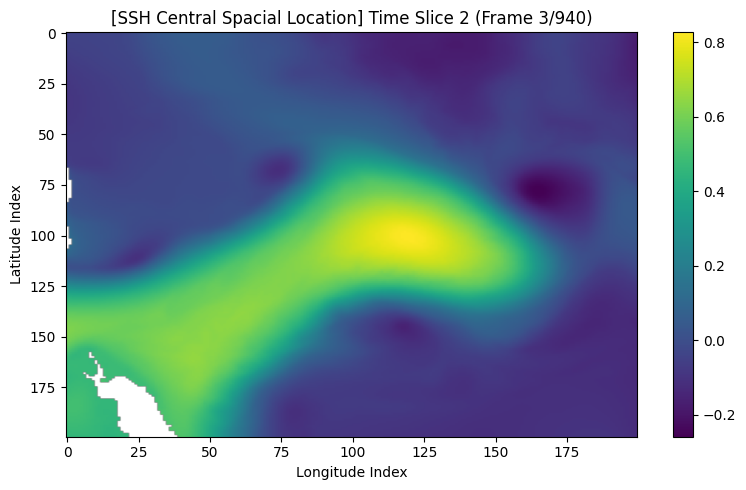


✅ Loop completed! Displayed 940 time slices, each for 1 second.


In [135]:
center = (n_lat // 2, n_lon // 2)

# Central spacial location
central_3d = data_3d[:, center[0]-100:center[0]+100, center[1]-100:center[1]+100]
visualize_data(central_3d, n_time, 'SSH Central Spacial Location')

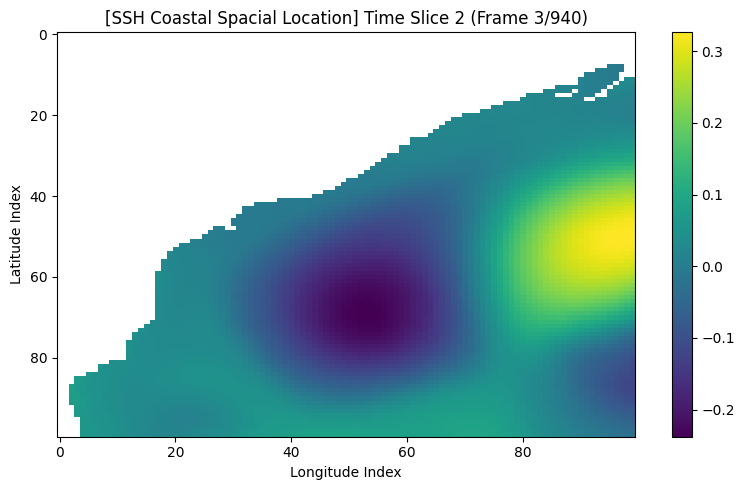


✅ Loop completed! Displayed 940 time slices, each for 1 second.


In [148]:
# Coastal spacial location
coastal_3d = data_3d[:, :100, :100]
visualize_data(coastal_3d, n_time, 'SSH Coastal Spacial Location')

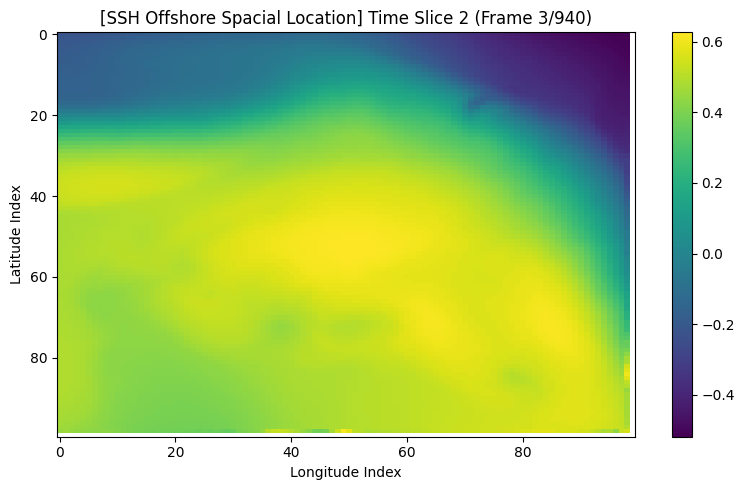


✅ Loop completed! Displayed 940 time slices, each for 1 second.


In [150]:
# Offshore spacial location
offshore_3d = data_3d[:, -100:, -100:]
visualize_data(offshore_3d, n_time, 'SSH Offshore Spacial Location')

# 2. Preprocess for Forecasting
- Use EOF analysis (SVD):
    - Reshape each SSH map into a vector → matrix  
    - Apply SVD:
        - D=UΣVT
    - Retain top k Principal Components (PCs) from UΣ
    - Use these PCs as input to your forecasting models

In [ ]:
# Parameters 
num_components = 10 # use top 3 PCs
sequence_length = 3
forecast_horizon = 4

# Reshape each SSH map into a vector → matrix  
anomaly_data_clean, valid_idx, data_2d, mean_data = svd_decompostion(data_3d, n_time)
# Apply SVD: [ D=UΣVT ]
# Retain top k Principal Components (PCs) from UΣ
EOFs, PCs = perform_svd(anomaly_data_clean, num_components)
# Use these PCs as input to your forecasting models
train_loader = generate_train_loader(PCs, sequence_length, forecast_horizon)




🔍 Performing SVD decomposition...
Reshaped data: (940, 208285) (time x space)


/var/folders/bk/7vhyrqzj5szgssr6vtc5gklr0000gn/T/ipykernel_58333/4266803111.py:9: RuntimeWarning: Mean of empty slice
  mean_data = np.nanmean(data_2d, axis=0)


Valid grid points: 150571 out of 208285
846 843


# 3. Implement Three Forecasting Models

### Model 1: Recurrent Neural Network (RNN)
- Define and implement.
- Forecast the next 10 weeks of SSH or PC values.


In [117]:
# Define and implement.
class RNNMultiPC(nn.Module):
    def __init__(self, input_dim, forecast_horizon):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32, input_dim * forecast_horizon)
        self.input_dim = input_dim
        self.horizon = forecast_horizon

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.view(-1, self.horizon, self.input_dim)


In [118]:
# Forecast the next 10 weeks of SSH or PC values.
model = train_NN(RNNMultiPC, num_components, forecast_horizon, train_loader)
true_fields, reconstructed_fields = generate_forecast(PCs, model, forecast_horizon, sequence_length, data_2d, EOFs, valid_idx, mean_data, n_lat, n_lon)
plot_forecast(true_fields, reconstructed_fields, 'RNN')


✅ GIF saved as 'forecast_vs_true_multiPC_(RNN).gif'


## Model 2: Long Short-Term Memory (LSTM)
- Define and implement.
- Forecast the next 10 weeks of SSH or PC values.

In [120]:
# Define and implement.
class LSTMMultiPC(nn.Module):
    def __init__(self, input_dim, forecast_horizon):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32, input_dim * forecast_horizon)
        self.input_dim = input_dim
        self.horizon = forecast_horizon

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.view(-1, self.horizon, self.input_dim)

In [122]:
# Forecast the next 10 weeks of SSH or PC values.
model = train_NN(LSTMMultiPC, num_components, forecast_horizon, train_loader)
true_fields, reconstructed_fields = generate_forecast(PCs, model, forecast_horizon, sequence_length, data_2d, EOFs, valid_idx, mean_data, n_lat, n_lon)
plot_forecast(true_fields, reconstructed_fields, 'LSTM')

✅ GIF saved as 'forecast_vs_true_multiPC_(LSTM).gif'
